<center>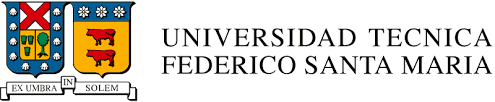</center>



<hr style="height:2px;border:none"/>
<h1 align='center'> Laureate Inc. Mexico </h1>

<H3 align='center'> Practica laboral  </H3>
<hr style="height:2px;border:none"/>

# Contexto

La empresa Laureate Inc. México se encuentra inmersa en un emocionante proyecto de mejora: la implementación de un chatbot respaldado por tecnologías de inteligencia artificial de vanguardia, como el chat GPT y otras plataformas similares. El propósito principal de esta iniciativa es simplificar y potenciar la comunicación entre los estudiantes provenientes de diversas instituciones afiliadas a Laureate Inc. México. A través de esta innovadora solución, los estudiantes tendrán la oportunidad de interactuar de manera efectiva con el chatbot para obtener información relevante y detallada acerca de las carreras que más despierten su interés. En las siguientes secciones, presentaremos algoritmos cuidadosamente diseñado que dará vida a esta visión, facilitando así el acceso a datos cruciales sobre las distintas trayectorias académicas disponibles

## 1.- Generar documentos txt para todas las carreras

Importaremos las librerias necesarias para cargar cada pdf y trabajar con ellos.

In [1]:
import os
import openai
import getpass
from langchain.vectorstores import FAISS
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from dotenv import load_dotenv, find_dotenv

from pypdf import PdfReader
import pathlib

### Es necesario obtener una OpenAI API KEY
#### Get your [OpenAI API Key](https://platform.openai.com/account/api-keys)

In [2]:
_ = load_dotenv(find_dotenv('.env/configuracion.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

En la base de datos poseemos distintas carpetas (clasificación) las cuales contienen los diferentes planes de carrerar (PDF). Es por esto que es necesario desarrollar un algoritmo que sea capaz de recorrer todos los PDF's y crear un archivo _.txt_ por cada archivo para posteriormente trabajar con estos.

In [3]:
def archivos_txt(carpeta):
    # Obtener el nombre de cada archivo pdf
    lista = []
    directorio = pathlib.Path(carpeta)
    for fichero in directorio.iterdir():
        if fichero.name != '.DS_Store':
            nombre = fichero.name[:-4]
            lista.append(nombre)
            
    # Recorrer cada archivo proveniente de la carpeta
    j = 0
    while j < len(lista):
        # Cargamos y abrimos un archivo
        direccion = carpeta+ lista[j] + '.pdf'
        loader = PyPDFLoader(direccion)
        pages = loader.load_and_split()
        # Es necesario obtener la cantidad de paginas que posee el archivo actual
        reader = PdfReader(direccion)
        number_of_pages = len(reader.pages)
    
        # Obtener una lista de tuplas, las cuales poseen la información de cada hoja. 
        texto_documento = []
        faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
        docs = faiss_index.similarity_search("De que trata la carrera?", k=number_of_pages)
        for doc in docs:
            nuevo_texto = (int(doc.metadata["page"]), doc.page_content[:])
            texto_documento.append(nuevo_texto)
        
        # Obtener un diccionario con la información de cada hoja
        diccionario_informacion = {}
        for tupla in texto_documento:
            pagina = tupla[0]
            texto = tupla[1]
    
            diccionario_informacion[pagina] = texto    
        
        # Obtener todo el texto del archivo actual
        pdf = ""
        for k in range(number_of_pages):
            nuevo_string = f"{diccionario_informacion[k]}"
            pdf += nuevo_string + '\n\n'
        
        # Crear un archivo .txt para cada archivo
        txt = open('txt/'+lista[j]+'.txt', "w", errors= 'ignore')
        txt.write(pdf)
        txt.close()
        
        j+=1
            

In [40]:
ciencias = 'pdf_files/pdf_files/ciencias_de_la_salud/'
ingenierias = 'pdf_files/pdf_files/ingenierias/'
licenciaturas = 'pdf_files/pdf_files/licenciatura/'

archivos_txt(ciencias)
archivos_txt(ingenierias)
archivos_txt(licenciaturas)

## Chat API : OpenAI

Ahora es el momento de leer cada uno de los archivos en formato .txt que hemos creado recientemente. Esto es necesario para utilizar las herramientas "langchain" y "chatgpt" y así generar archivos JSON para cada uno de estos archivos de texto. Vamos a comenzar haciendo una llamada directa a la API de OpenAI.

In [41]:
def get_completion(prompt, model="gpt-3.5-turbo-16k"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    return response.choices[0].message["content"]

In [42]:
def archivos_json():
    # Obtener el nombre de cada archivo txt
    lista = []
    directorio = pathlib.Path('txt')
    for fichero in directorio.iterdir():
        json = open('txt/'+fichero.name, "r", errors= 'ignore')
        texto = json.read()
        json.close()
        
        style = """Español Mexicano \ respetuoso"""

        prompt = f"""Structure the following text \
        that is delimited by triple backticks 
        into a style that is {style}.
        text: ```{texto}``` in a JSON with the following fields,
        
        Title: <titulo de la página>
        Paragraphs: <[number: <numero del parrafo>, text: <texto parrafo>, keywords: <list of 10 keywords most relevant separated by coma>]>

        """
        response = get_completion(prompt)
        print(response)
        

In [43]:
archivos_json()

{
  "Title": "Licenciatura en Comunicación y Medios Digitales",
  "Paragraphs": [
    {
      "number": 1,
      "text": "Esta Licenciatura es para ti si te interesa... Ser parte de la transformación digital en materia de comunicación. Profundizar en nociones del contexto nacional. Elaborar contenidos y mensajes para cualquier canal (electrónico o tradicional). Ser un protagonista en la evolución de los canales y los medios de comunicación.",
      "keywords": ["Licenciatura en Comunicación y Medios Digitales", "transformación digital", "comunicación", "contenidos", "mensajes", "canales", "medios de comunicación"]
    },
    {
      "number": 2,
      "text": "Al concluir el programa serás capaz de: Generar contenidos multimedia, hipermedia y transmedia con una postura crítica. Estructurar contenidos orales y escritos desde la perspectiva del usuario. Diseñar planes de comunicación internos y externos que fortalezcan a la empresa. Gestionar contenidos que permitan la vinculación entre 

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

In [62]:
def archivos_txt2(carpeta):
    # Obtener el nombre de cada archivo pdf
    lista = []
    directorio = pathlib.Path(carpeta)
    for fichero in directorio.iterdir():
        if fichero.name != '.DS_Store':
            nombre = fichero.name[:-4]
            lista.append(nombre)
            
    # Recorrer cada archivo proveniente de la carpeta
    j = 0
    while j < len(lista):
        # Cargamos y abrimos un archivo
        direccion = carpeta+ lista[j] + '.pdf'
        loader = PyPDFLoader(direccion)
        pages = loader.load_and_split()
        # Es necesario obtener la cantidad de paginas que posee el archivo actual
        reader = PdfReader(direccion)
        number_of_pages = len(reader.pages)
    
        # Obtener una lista de tuplas, las cuales poseen la información de cada hoja. 
        texto_documento = []
        faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
        docs = faiss_index.similarity_search("De que trata la carrera?", k=number_of_pages)
        for doc in docs:
            nuevo_texto = (int(doc.metadata["page"]), doc.page_content[:])
            texto_documento.append(nuevo_texto)
        
        # Obtener un diccionario con la información de cada hoja
        diccionario_informacion = {}
        for tupla in texto_documento:
            pagina = tupla[0]
            texto = tupla[1]
    
            diccionario_informacion[pagina] = texto    
        
        # Obtener todo el texto del archivo actual
        pdf = ""
        for k in range(number_of_pages):
            nuevo_string = f"{diccionario_informacion[k]}"
            #pdf += f"Página #{k}:"
            pdf += nuevo_string + '\n\n'
        
        # Crear un archivo .txt para cada archivo
        txt = open('txt/'+lista[j]+'.txt', "w", errors= 'ignore')
        txt.write(pdf)
        txt.close()
        
        j+=1
         

In [63]:
ciencias = 'pdf_files/pdf_files/ciencias_de_la_salud/'
archivos_txt2(ciencias)

In [64]:
with open('txt/645af6d2b859a503108939.txt', 'r') as file:
    content = file.read()

# Divide el contenido en párrafos basados en los saltos de línea
paragraphs = content.split('\n')  # salto de línea indica un nuevo párrafo

# Imprime los párrafos
for idx, paragraph in enumerate(paragraphs, start=1):
    print(f'Párrafo {idx}:')
    print(paragraph)
    print('-' * 40)

Párrafo 1:
LICENCIATURA 
----------------------------------------
Párrafo 2:
EN MEDICINA VETERINARIA Y ZOOTECNIA
----------------------------------------
Párrafo 3:

----------------------------------------
Párrafo 4:
Licenciaturas
----------------------------------------
Párrafo 5:
Per/f_il de ingreso
----------------------------------------
Párrafo 6:
Esta Licenciatura es para ti si te interesa...
----------------------------------------
Párrafo 7:
Prevenir, diagnosticar y tratar 
----------------------------------------
Párrafo 8:
enfermedades en pequeñas y grandes especies.
----------------------------------------
Párrafo 9:
Aprender /f_isioterapia y rehabilitación de perros y gatos.Cuidar animales y convivir con ellos.
----------------------------------------
Párrafo 10:
Entender la estructura, funcionamiento 
----------------------------------------
Párrafo 11:
y alteraciones del organismo animal.
----------------------------------------
Párrafo 12:
Emprender en tu propia clínica

In [60]:
def archivos_json2():
    # Obtener el nombre de cada archivo txt
    lista = []
    directorio = pathlib.Path('txt')
    for fichero in directorio.iterdir():
        json = open('txt/'+'645af6d2b859a503108939.txt', "r", errors= 'ignore')
        texto = json.read()
        json.close()
        
        style = """Español Mexicano \ respetuoso"""

        prompt = f"""Structure the following text \
        that is delimited by triple backticks 
        into a style that is {style}.
        text: ```{texto}``` in a JSON with the following fields,
        
        Title: <titulo de la página>
        Paragraphs: <[number: <numero del parrafo>, text: <texto parrafo>, keywords: <list of 10 keywords most relevant separated by coma>]>

        """
        response = get_completion(prompt)
        print(response)

In [61]:
archivos_json2()

{
  "Title": "Licenciatura en Medicina Veterinaria y Zootecnia",
  "Paragraphs": [
    {
      "number": 1,
      "text": "Esta Licenciatura es para ti si te interesa... Prevenir, diagnosticar y tratar enfermedades en pequeñas y grandes especies. Aprender fisioterapia y rehabilitación de perros y gatos. Cuidar animales y convivir con ellos. Entender la estructura, funcionamiento y alteraciones del organismo animal. Emprender en tu propia clínica veterinaria.",
      "keywords": ["Licenciatura", "Medicina Veterinaria", "Zootecnia", "enfermedades", "perros", "gatos", "animales", "organismo animal", "clínica veterinaria"]
    },
    {
      "number": 2,
      "text": "Al concluir el programa serás capaz de: Aplicar métodos de diagnóstico con equipos médicos avanzados. Identificar y tratar alteraciones patológicas. Diagnosticar y tratar enfermedades alimentarias en diversas especies animales. Comprender las bases biológicas de los procesos del organismo animal.",
      "keywords": ["diagnó

KeyboardInterrupt: 